In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from sklearn.linear_model import LogisticRegression as LR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
import json

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from util import *

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [28]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)

test_dset,num_classes = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
t = templates[0]

# Normal
predictions, actual, probs = get_preds(model, tokenizer, test_dset, text_template=t, device=device)
ECE, _, acc = get_metrics(predictions, actual, probs)
bins, _, bin_accs, _, bin_sizes = calc_bins(predictions, actual, probs)

# Supervised Temp
scaled_temp = run_supervised_tempscaling(model, tokenizer, val_dset, t, device)
predictions, actual, probs_scaled_sup = get_preds(model, tokenizer, test_dset, text_template=t, temp_scaling=scaled_temp)
ECE_scaled_sup, _, acc_scaled_sup = get_metrics(predictions, actual, probs_scaled_sup)
bins_scaled_sup, _, bin_accs_scaled_sup, _, bin_sizes_scaled_sup = calc_bins(predictions, actual, probs_scaled_sup)

# Found on Imagenet Temp
scaled_temp = 1.6131701469421387#find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
predictions, actual, probs_scaled = get_preds(model, tokenizer, test_dset, text_template=t, temp_scaling=scaled_temp)
ECE_scaled, _, acc_scaled = get_metrics(predictions, actual, probs_scaled)
bins_scaled, _, bin_accs_scaled, _, bin_sizes_scaled = calc_bins(predictions, actual, probs_scaled)

In [30]:
dataset_name = 'CIFAR100'

test_dset,num_classes = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

# Normal 
predictions, actual, probs_cifar100 = get_preds(model, tokenizer, test_dset, text_template=t, device=device)
ECE_cifar100, _, acc = get_metrics(predictions, actual, probs_cifar100)
bins_cifar100, _, bin_accs_cifar100, _, bin_sizes_cifar100 = calc_bins(predictions, actual, probs_cifar100)

# Supervised Temp
scaled_temp = run_supervised_tempscaling(model, tokenizer, val_dset, t, device)
predictions, actual, probs_scaled_sup_cifar100  = get_preds(model, tokenizer, test_dset, text_template=t, temp_scaling=scaled_temp)
ECE_scaled_sup_cifar100 , _, acc_scaled_sup_cifar100  = get_metrics(predictions, actual, probs_scaled_sup_cifar100 )
bins_scaled_sup_cifar100 , _, bin_accs_scaled_sup_cifar100 , _, bin_sizes_scaled_sup_cifar100 = calc_bins(predictions, actual, probs_scaled_sup_cifar100 )

# Found on CIFAR Temp
scaled_temp = 1.6131701469421387#find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
predictions, actual, probs_scaled_cifar100 = get_preds(model, tokenizer, test_dset, text_template=t, temp_scaling=scaled_temp)
ECE_scaled_cifar100, _, acc_scaled = get_metrics(predictions, actual, probs_scaled_cifar100)
bins_scaled_cifar100, _, bin_accs_scaled_cifar100, _, bin_sizes_scaled_cifar100 = calc_bins(predictions, actual, probs_scaled_cifar100)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
dataset_name = 'SUN397'

test_dset,num_classes = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

# Normal 
predictions, actual, probs_sun397 = get_preds(model, tokenizer, test_dset, text_template=t, device=device)
ECE_sun397, _, acc = get_metrics(predictions, actual, probs_sun397)
bins_sun397, _, bin_accs_cifar100, _, bin_sizes_sun397 = calc_bins(predictions, actual, probs_sun397)

# Supervised Temp
scaled_temp = run_supervised_tempscaling(model, tokenizer, val_dset, t, device)
predictions, actual, probs_scaled_sup_sun397 = get_preds(model, tokenizer, test_dset, text_template=t, temp_scaling=scaled_temp)
ECE_scaled_sup_sun397 , _, acc_scaled_sup_sun397  = get_metrics(predictions, actual, probs_scaled_sup_sun397 )
bins_scaled_sup_sun397 , _, bin_accs_scaled_sup_sun397 , _, bin_sizes_scaled_sup_sun397= calc_bins(predictions, actual, probs_scaled_sup_sun397 )

# Found on CIFAR Temp
scaled_temp = 1.6131701469421387#find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
predictions, actual, probs_scaled_sun397 = get_preds(model, tokenizer, test_dset, text_template=t, temp_scaling=scaled_temp)
ECE_scaled_sun397, _, acc_scaled = get_metrics(predictions, actual, probs_scaled_sun397)
bins_scaled_sun397, _, bin_accs_scaled_sun397, _, bin_sizes_scaled_sun397 = calc_bins(predictions, actual, probs_scaled_sun397)

Text(-2.085, 0.04, 'Sample frac.')

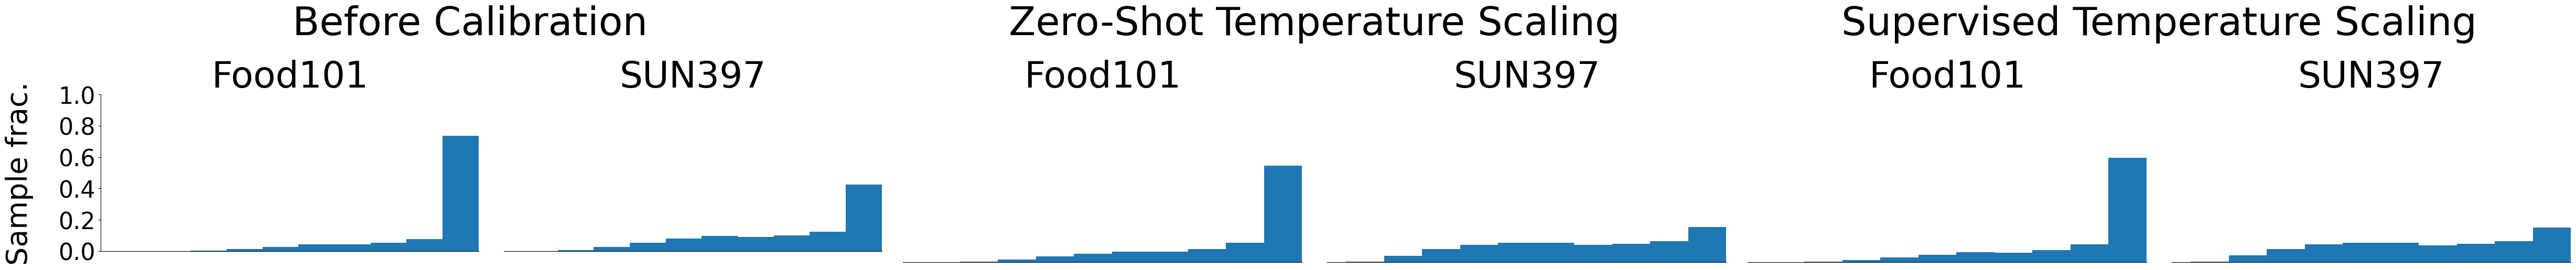

In [15]:
import matplotlib
# Plot histogram confidences
matplotlib.rc('xtick', labelsize=32) 
matplotlib.rc('ytick', labelsize=32) 
fig = plt.figure( constrained_layout=True, figsize=(48,4))
#fig.suptitle('Reliability Diagram', fontsize=32)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=1, ncols=3)
names = {
    0 : 'Before Calibration',
    1 : 'Zero-Shot Temperature Scaling',
    2 : 'Supervised Temperature Scaling'
}

for row, subfig in enumerate(subfigs):
    subfig.suptitle(names[row], fontsize=54, y=1.25)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        #if row == 0:
        if col == 0:
                ax.set_title('Food101', fontsize=50)
        else:
                ax.set_title('SUN397', fontsize=50)
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        #ax.axes.get_xaxis().set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        if not (row ==0 and col == 0):
                ax.axes.get_yaxis().set_visible(False)
                ax.spines[['left']].set_visible(False)
        else:
            ax.set_yticks(np.arange(0, 1.01, 0.2), loc="top")
            

#x,_, p = plt.hist()
#for item in p:
#    item.set_height(item.get_height()/sum(x))
#plt.ylim([0,1.0])

xbins = np.insert(bins, 0, 0.0)


# Before Calibration
axarr = subfigs[0].get_axes()
for i, pr in enumerate([probs, probs_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  

# Scaled
axarr = subfigs[1].get_axes()
for i, pr in enumerate([probs_scaled, probs_scaled_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  

# Supervised
axarr = subfigs[2].get_axes()
for i, pr in enumerate([probs_scaled_sup, probs_scaled_sup_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  


#subfigs[-1].text(0,-0.08, 'Confidence', ha='center', fontsize=28)
subfigs[-1].text(-2.085,0.04, 'Sample frac.', ha='center', rotation=90, fontsize=40)


Text(-2.08, 0.4, 'Accuracy')

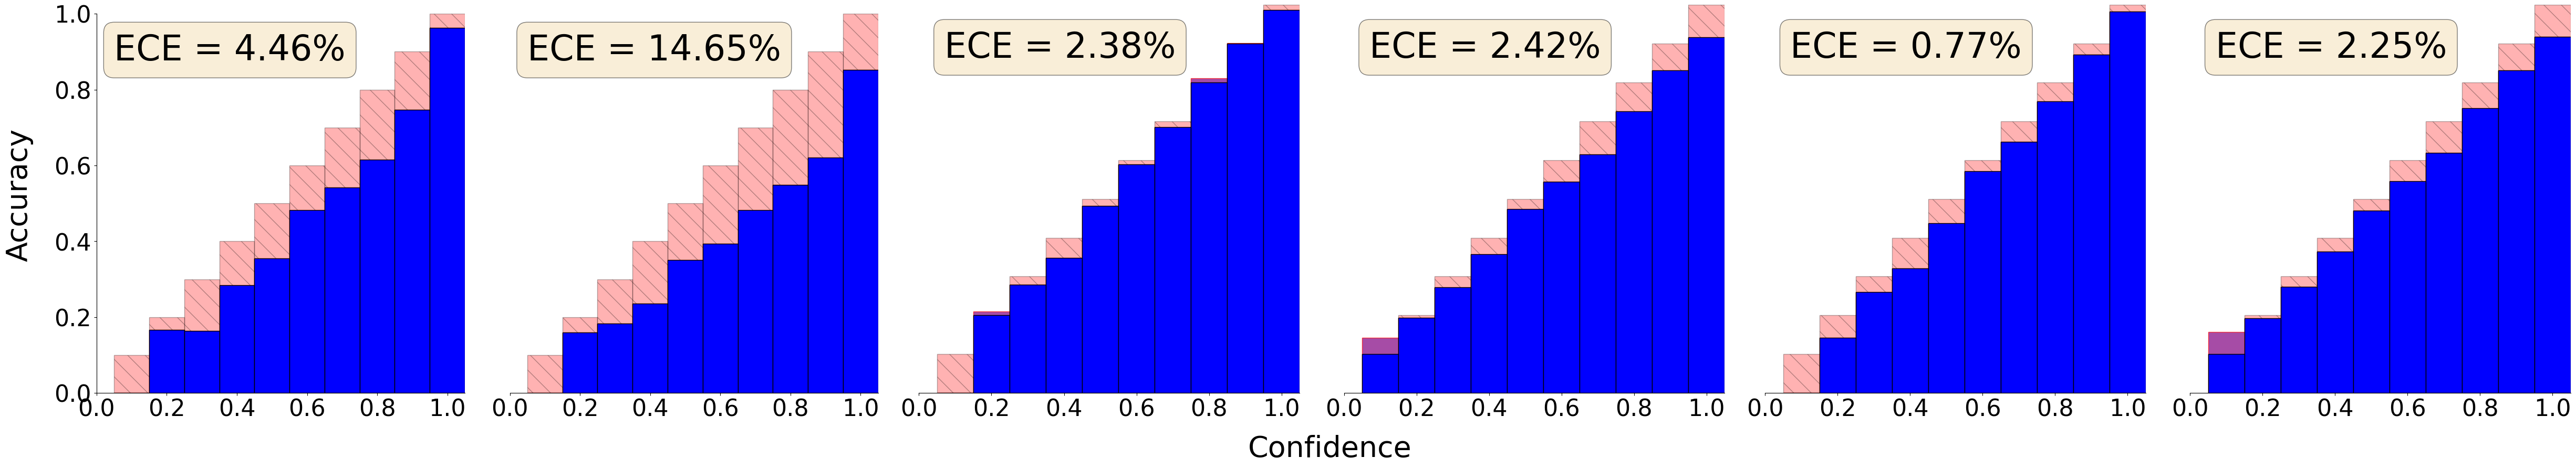

In [16]:
import matplotlib

matplotlib.rc('xtick', labelsize=32) 
matplotlib.rc('ytick', labelsize=32) 
fig = plt.figure( constrained_layout=True, figsize=(48,8))
#fig.suptitle('Reliability Diagram', fontsize=32)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=1, ncols=3)
names = {
    0 : 'Before Calibration',
    1 : 'Zero-Shot Temperature Scaling',
    2 : 'Supervised Temperature Scaling'
}

for row, subfig in enumerate(subfigs):
    #subfig.suptitle(names[row], fontsize=30, y=1.07)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        #if row == 0:
        #if col == 0:
        #        ax.set_title('CIFAR10', fontsize=28)
        #else:
        #        ax.set_title('CIFAR100', fontsize=28)
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1)
        ax.set_xticks(np.arange(0,1.01, 0.2))
        ax.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

        #ax.plot([0,1],[0,1], '--', color='gray', linewidth=2)
        #ax.set_aspect('equal', adjustable='box')
        ax.spines[['right', 'top']].set_visible(False)
        if not (row ==0 and col == 0):
                ax.axes.get_yaxis().set_visible(False)
                ax.spines[['left']].set_visible(False)

ece_fontsize=48
# Before Calibration
# CIFAR10
axarr = subfigs[0].get_axes()
axarr[0].bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins, np.minimum(bins, bin_accs), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE*100),  fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# CIFAR100
axarr[1].bar(bins_cifar100, bin_accs_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_cifar100, np.minimum(bins_cifar100, bin_accs_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')
axarr[1].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE_cifar100*100), fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        

# Scaled CIFAR10
axarr = subfigs[1].get_axes()
axarr[0].bar(bins_scaled, bin_accs_scaled, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins_scaled, np.minimum(bins_scaled, bin_accs_scaled), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_scaled*100),  fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Scaled CIFAR100
axarr[1].bar(bins_scaled_cifar100, bin_accs_scaled_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_scaled_cifar100, np.minimum(bins_scaled_cifar100,bin_accs_scaled_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[1].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_scaled_cifar100*100),  fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Supervised CIFAR10
axarr = subfigs[2].get_axes()
axarr[0].bar(bins_scaled_sup, bin_accs_scaled_sup, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins_scaled_sup, np.minimum(bins_scaled_sup, bin_accs_scaled_sup), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_scaled_sup*100), fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Supervised CIFAR100
axarr[1].bar(bins_scaled_sup_cifar100, bin_accs_scaled_sup_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_scaled_sup_cifar100, np.minimum(bins_scaled_sup_cifar100,bin_accs_scaled_sup_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[1].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_scaled_sup_cifar100*100), fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))





subfigs[-1].text(-0.5,-0.08, 'Confidence', ha='center', fontsize=40)
subfigs[-1].text(-2.08,0.4, 'Accuracy', ha='center', rotation=90, fontsize=40)

In [37]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR100'
num_classes = 100

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)


eces_scaled = []
eces = []
accs_scaled = []
temps = []

image_features, actual = get_image_features(
    model,  cifar_test,  batch_size=batch_size, device=device
)

for t in tqdm(templates):
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    predictions, probs = get_preds_from_img_features(model, tokenizer, cifar_test, image_features, text_template=t,
                        device = device)
    ece, _, acc = get_metrics(predictions, actual, probs)
    eces.append(ece)

    scaled_temp = 1.6131701469421387#find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    predictions, probs = get_preds_from_img_features(model, tokenizer, cifar_test, image_features, text_template=t, temp_scaling=scaled_temp,
                        device = device)
    ece, _, acc = get_metrics(predictions, actual, probs)
    eces_scaled.append(ece)
    temps.append(scaled_temp)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


In [38]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'
num_classes = 10

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
val_dset = get_val_set(dataset_name, classes, preprocess)

eces_scaled_cifar10 = []
eces_cifar10 = []
accs_scaled_cifar10 = []
temps_cifar10 = []

image_features, actual = get_image_features(
    model,  cifar_test,  batch_size=batch_size, device=device
)

for t in tqdm(templates):
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    predictions, probs = get_preds_from_img_features(model, tokenizer, cifar_test, image_features, text_template=t,
                        device = device)
    ece_cifar10, _, acc = get_metrics(predictions, actual, probs)
    eces_cifar10.append(ece_cifar10)

    scaled_temp = 1.6131701469421387#find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    predictions, probs = get_preds_from_img_features(model, tokenizer, cifar_test, image_features, text_template=t, temp_scaling=scaled_temp,
                        device = device)
    ece_cifar10, _, acc = get_metrics(predictions, actual, probs)
    eces_scaled_cifar10.append(ece_cifar10)
    temps_cifar10.append(scaled_temp)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 18/18 [00:00<00:00, 29.82it/s]


In [39]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'

dataset_name = 'SUN397'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

test_dset,num_classes = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

tokenizer = open_clip.get_tokenizer(model_name)

eces_scaled_sun = []
eces_sun = []
accs_scaled_sun = []
temps_sun = []

image_features, actual = get_image_features(
    model,  test_dset,  batch_size=batch_size, device=device
)

for t in tqdm(templates):
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t)
    predictions, probs = get_preds_from_img_features(model, tokenizer, test_dset, image_features, text_template=t,
                        device = device)
    ece_sun, _, acc = get_metrics(predictions, actual, probs)
    eces_sun.append(ece_sun)

    scaled_temp = 1.6131701469421387#find_temp_scale(model, tokenizer, val_dset, num_classes=num_classes, text_template=t)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=t, temp_scaling=scaled_temp)
    predictions, probs = get_preds_from_img_features(model, tokenizer, test_dset, image_features, text_template=t, temp_scaling=scaled_temp,
                        device = device)
    ece_sun, _, acc = get_metrics(predictions, actual, probs)
    eces_scaled_sun.append(ece_sun)
    temps_sun.append(scaled_temp)

100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Text(0.5, -0.54, 'Prompt Template')

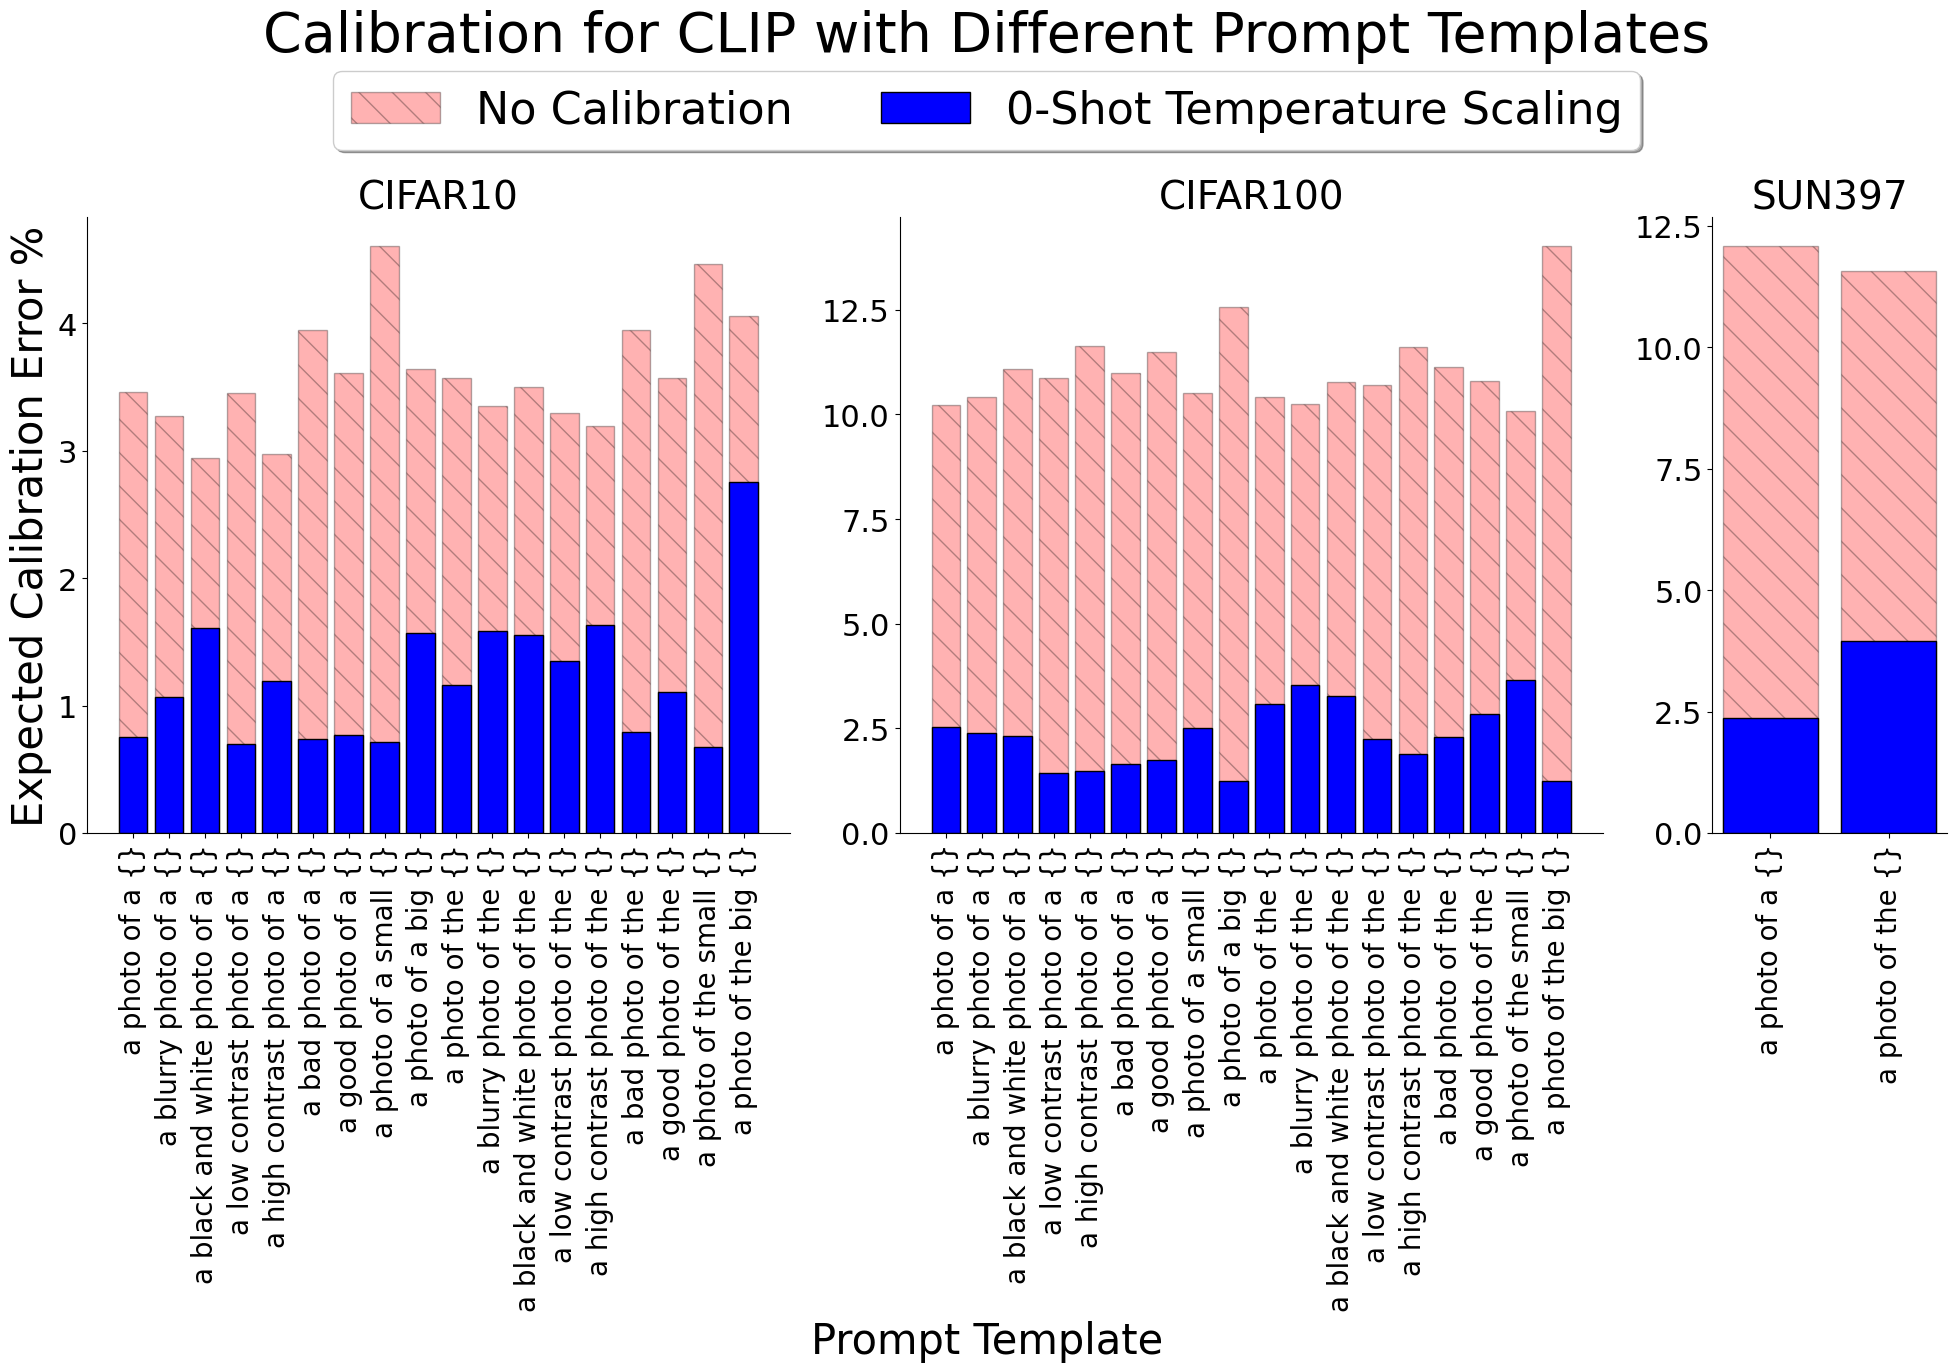

In [53]:
#fig, axarr = plt.subplots(1,3, figsize=(24, 8))
fig = plt.figure(figsize=(24,8)) 
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[3, 3, 1])

axarr = [plt.subplot(g) for g in gs]

for ax in axarr:
    # x/y labels
    #ax.set_xlabel('Prompt Template', fontsize=24)
    #ax.set_ylabel('Expected Calibration Error %', fontsize=24)

    # Create grid
    #ax.set_axisbelow(True) 
    #ax.grid(color='gray', linestyle='dashed')
    ax.spines[['right', 'top']].set_visible(False)

axarr[0].set_ylabel('Expected Calibration Error %', fontsize=30)
_, templates = get_openai_prompts('CIFAR100')
xaxis = [x[:-1] for x in templates]

_, templates = get_openai_prompts('SUN397')
xaxis_sun = [x[:-1] for x in templates]


axarr[0].bar(xaxis, np.array(eces_cifar10) * 100.0,  width=0.8, alpha=0.3, edgecolor='black', color='r', hatch='\\', label = 'No Calibration')
axarr[0].bar(xaxis, np.array(eces_scaled_cifar10) * 100.0, width=0.8, alpha=1, edgecolor='black', color='b', label = '0-Shot Temperature Scaling')

axarr[1].bar(xaxis, np.array(eces) * 100.0,  width=0.8, alpha=0.3, edgecolor='black', color='r', hatch='\\', label = 'No Calibration')
axarr[1].bar(xaxis, np.array(eces_scaled) * 100.0, width=0.8, alpha=1, edgecolor='black', color='b', label = '0-Shot Temperature Scaling')

axarr[2].bar(xaxis_sun, np.array(eces_sun) * 100.0,  width=0.8, alpha=0.3, edgecolor='black', color='r', hatch='\\', label = 'No Calibration')
axarr[2].bar(xaxis_sun, np.array(eces_scaled_sun) * 100.0, width=0.8, alpha=1, edgecolor='black', color='b', label = '0-Shot Temperature Scaling')


axarr[0].set_title('CIFAR10', fontsize=28)
axarr[1].set_title('CIFAR100', fontsize=28)
axarr[2].set_title('SUN397', fontsize=28)

#for ax in axarr:
    #ax.set_xticklabels(templates[1:], rotation=90, fontsize=14)
    #ax.set_yticklabels([txt.get_text() for txt in ax.get_yticklabels()],  fontsize=14)
    #ax.set_aspect('equal', adjustable='box')
handles, labels = axarr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fancybox=True, shadow=True, fontsize=32, bbox_to_anchor=(0.5, 1.09))
#axarr[0].legend(bbox_to_anchor=(0.45, 1.47), fancybox=True, shadow=True, loc='upper center')
# ECE and MCE legend
#ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
#MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
#acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
#plt.legend(handles=[ECE_patch, MCE_patch, acc_patch])
plt.suptitle('Calibration for CLIP with Different Prompt Templates', y = 1.14, fontsize=40)

for ax in axarr:
    plt.sca(ax)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=22)
    ax.xaxis.set_label_coords(0.5,-0.9)

fig.text(0.5, -0.54, 'Prompt Template', ha='center', fontsize=30)
#plt.tight_layout()


#plt.save_fig('plots/main_reliability.jpg')

Against Supervised Methods

In [5]:
def run_isotonic(labels_val, preds_val, probs_val, y_preds_proba_test):
    ir = IR( out_of_bounds = 'clip' )
    _, _, bin_accs_val, bin_confs_val, _ = calc_bins(labels_val, preds_val, probs_val)
    ir.fit( bin_confs_val, bin_accs_val )
    p_calibrated = ir.transform( y_preds_proba_test )
    return p_calibrated

In [6]:
def run_decisiontree(labels_val, preds_val, probs_val, y_preds_proba_test):
    dt = DT()
    _, _, bin_accs_val, bin_confs_val, _ = calc_bins(labels_val, preds_val, probs_val)
    dt.fit( np.expand_dims(bin_confs_val,1), np.expand_dims(bin_accs_val,1) )
    p_calibrated = dt.predict( np.expand_dims(y_preds_proba_test,1) )
    return p_calibrated

In [7]:
def run_uts(model, tokenizer, dset,  image_features, text_template):

    text = tokenizer([text_template.replace('{}',x) for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T)

    ## Get threshold
    text_probs_numpy = text_probs.softmax(dim=-1).cpu().numpy()

    ## Setup LBGFS
    temperature = nn.Parameter((torch.ones(1)).to(device))
    args = {'temperature': temperature}
    criterion = nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')

    logits_list = []
    labels_list = []

    predicted_label = text_probs_numpy.argmax(axis=1)

    added = np.zeros(len(text_probs_numpy[0]))
    for k in range(len(text_probs_numpy[0])):
        # set where predicted_label is not k
        logits_u = text_probs_numpy[predicted_label != k,:]

        mean_softmax_yk = logits_u[:,k].mean()
        std_softmax_yk = logits_u[:,k].std()

        thresh = mean_softmax_yk + 1.0 * std_softmax_yk
        for j in np.where(text_probs_numpy[:,k] >= thresh)[0]:
            added[k] += 1
            logits_list.append(text_probs[j].unsqueeze(0))
            labels_list.append(k)

    logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
    labels_list = torch.FloatTensor(labels_list).to(device).long()

    temps = []
    losses = []
    def _eval():
        loss = criterion(T_scaling(logits_list, args), labels_list)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss

    optimizer.step(_eval)
    return temperature.item()

In [165]:
def run_plattscaling(model, tokenizer, val_dset, text_template, test_dset, y_true_val):
    #lr = LR()  
    #_, _, bin_accs_val, bin_confs_val, _ = calc_bins(labels_val, preds_val, probs_val)
    #lr.fit( np.expand_dims(bin_confs_val,1), np.expand_dims(bin_accs_val,1) )
    #lr.fit( np.expand_dims(probs_val,1), labels_val )
    #p_calibrated = lr.predict_proba( np.expand_dims(y_preds_proba_test,1) )
    #return p_calibrated

    text_probs_val = get_text_probs(model, tokenizer, val_dset,
        text_template=text_template, batch_size=128, device =device)
    text_probs_test = get_text_probs(model, tokenizer, test_dset,
            text_template=text_template, batch_size=128, device =device)
    lr = LR(C=1e10, solver='lbfgs')
    lr.fit( text_probs_val.cpu().numpy(), y_true_val)
    platt_probs = lr.predict_proba( text_probs_test.cpu().numpy()).max(axis=1)
    return platt_probs

In [24]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

tokenizer = open_clip.get_tokenizer(model_name)

classes, templates = get_openai_prompts(dataset_name)
text_template = templates[0]
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)

predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, device=device)
y_preds_val, y_true_val, y_preds_proba_val = get_preds(model, tokenizer, val_dset, text_template=text_template)
p_calibrated_iso = run_isotonic(y_true_val, y_preds_val, y_preds_proba_val, probs)
#get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_iso)[0]
ECE_iso_cifar10, _, _ = get_metrics(predictions, actual, p_calibrated_iso)
bins_iso_cifar10, _, bin_accs_iso_cifar10, _, bin_sizes_histobin_cifar10 = calc_bins(predictions, actual, p_calibrated_iso)

### 
dataset_name = 'CIFAR100'
classes, templates = get_openai_prompts(dataset_name)
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)

predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_template=text_template, device=device)
y_preds_val, y_true_val, y_preds_proba_val = get_preds(model, tokenizer, val_dset, text_template=text_template)
p_calibrated_iso_cifar100 = run_isotonic(y_true_val, y_preds_val, y_preds_proba_val, probs)
#get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_iso)[0]
ECE_iso_cifar100, _, _ = get_metrics(predictions, actual, p_calibrated_iso_cifar100)
bins_iso_cifar100, _, bin_accs_iso_cifar100, _, bin_sizes_histobin_cifar100 = calc_bins(predictions, actual, p_calibrated_iso_cifar100)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [23]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)
tokenizer = open_clip.get_tokenizer(model_name)

classes, templates = get_openai_prompts(dataset_name)
text_template = templates[0]
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)


predictions, actual, probs_histobin = get_preds(model, tokenizer, cifar_test, text_template=text_template, device=device)
y_preds_val, y_true_val, y_preds_proba_val = get_preds(model, tokenizer, val_dset, text_template=text_template)
p_calibrated_dt = run_decisiontree(y_true_val, y_preds_val, y_preds_proba_val, probs_histobin)
#get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_dt)[0]
ECE_histobin_cifar10, _, _ = get_metrics(predictions, actual, p_calibrated_dt)
bins_histobin_cifar10, _, bin_accs_histobin_cifar10, _, bin_sizes_histobin_cifar10 = calc_bins(predictions, actual, p_calibrated_dt)

# CIFAR100
dataset_name = 'CIFAR100'
classes, templates = get_openai_prompts(dataset_name)
text_template = templates[0]
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)


predictions, actual, probs_histobin_cifar100 = get_preds(model, tokenizer, cifar_test, text_template=text_template, device=device)
y_preds_val, y_true_val, y_preds_proba_val = get_preds(model, tokenizer, val_dset, text_template=text_template)
p_calibrated_dt_cifar100 = run_decisiontree(y_true_val, y_preds_val, y_preds_proba_val, probs_histobin_cifar100)
#get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_dt)[0]
ECE_histobin_cifar100, _, _ = get_metrics(predictions, actual, p_calibrated_dt_cifar100)
bins_histobin_cifar100, _, bin_accs_histobin_cifar100, _, bin_sizes_histobin_cifar100 = calc_bins(predictions, actual, p_calibrated_dt_cifar100)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [166]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)

classes, templates = get_openai_prompts(dataset_name)
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)

_, actual, _ = get_preds(model, tokenizer, cifar_test, text_template=t, device=device)
#y_preds_val, y_true_val, y_preds_proba_val = get_preds(model, tokenizer, val_dset, text_template=t)
#p_calibrated_platt = run_plattscaling(y_true_val, y_preds_val, y_preds_proba_val, probs)
#get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_platt)[0]
p_calibrated_platt = run_plattscaling(model, tokenizer, val_dset, text_template, cifar_test, actual)
get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_platt)[0]

Files already downloaded and verified
Files already downloaded and verified


ValueError: Unknown label type: 'continuous'

In [167]:
p_calibrated_platt = run_plattscaling(model, tokenizer, val_dset, text_template, cifar_test, actual)
get_metrics(actual, predictions, probs)[0], get_metrics(actual, predictions, p_calibrated_platt)[0]

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.034525964367322824, 0.8013243664066916)

In [169]:
text_probs_val = get_text_probs(model, tokenizer, val_dset,
        text_template=t, batch_size=128, device =device)
text_probs_test = get_text_probs(model, tokenizer, cifar_test,
        text_template=t, batch_size=128, device =device)

In [170]:
lr = LR(C=1e10, solver='lbfgs')
#_, _, bin_accs_val, bin_confs_val, _ = calc_bins(labels_val, preds_val, probs_val)
#lr.fit( np.expand_dims(bin_confs_val,1), np.expand_dims(bin_accs_val,1) )
lr.fit( text_probs_val.cpu().numpy(), y_true_val)
platt_probs = lr.predict_proba( text_probs.cpu().numpy()).max(axis=1)
get_metrics(predictions, actual, probs )[0], get_metrics(predictions, actual, platt_probs )[0]

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.034525964367322824, 0.026292592304516575)

In [22]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR10'

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)
tokenizer = open_clip.get_tokenizer(model_name)

classes, templates = get_openai_prompts(dataset_name)
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)

text_template = templates[0]
image_features, actual = get_image_features(
    model,  val_dset,  batch_size=batch_size, device=device
)
temp = run_uts(model, tokenizer, val_dset,  image_features, text_template)

predictions_uts, actual_uts, probs_uts = get_preds(model, tokenizer, cifar_test, text_template=text_template, device=device, temp_scaling=temp)
#get_metrics(predictions_uts, actual_uts, probs_uts )[0]
ECE_utc_cifar10, _, _ = get_metrics(predictions_uts, actual_uts, probs_uts)
bins_utc_cifar10, _, bin_accs_utc_cifar10, _, bin_sizes_utc_cifar10 = calc_bins(predictions_uts, actual_uts, probs_uts)

###
dataset_name = 'CIFAR100'
classes, templates = get_openai_prompts(dataset_name)
cifar_test, num_classes = get_test_set(dataset_name, preprocess)
val_dset = get_val_set(dataset_name, classes, preprocess)

text_template = templates[0]
image_features, actual = get_image_features(
    model,  val_dset,  batch_size=batch_size, device=device
)
temp = run_uts(model, tokenizer, val_dset,  image_features, text_template)

predictions_uts, actual_uts, probs_uts_cifar100 = get_preds(model, tokenizer, cifar_test, text_template=text_template, device=device, temp_scaling=temp)
#get_metrics(predictions_uts, actual_uts, probs_uts )[0]
ECE_utc_cifar100, _, _ = get_metrics(predictions_uts, actual_uts, probs_uts_cifar100)
bins_utc_cifar100, _, bin_accs_utc_cifar100, _, bin_sizes_utc_cifar100 = calc_bins(predictions_uts, actual_uts, probs_uts_cifar100)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Text(-2.08, 0.4, 'Accuracy')

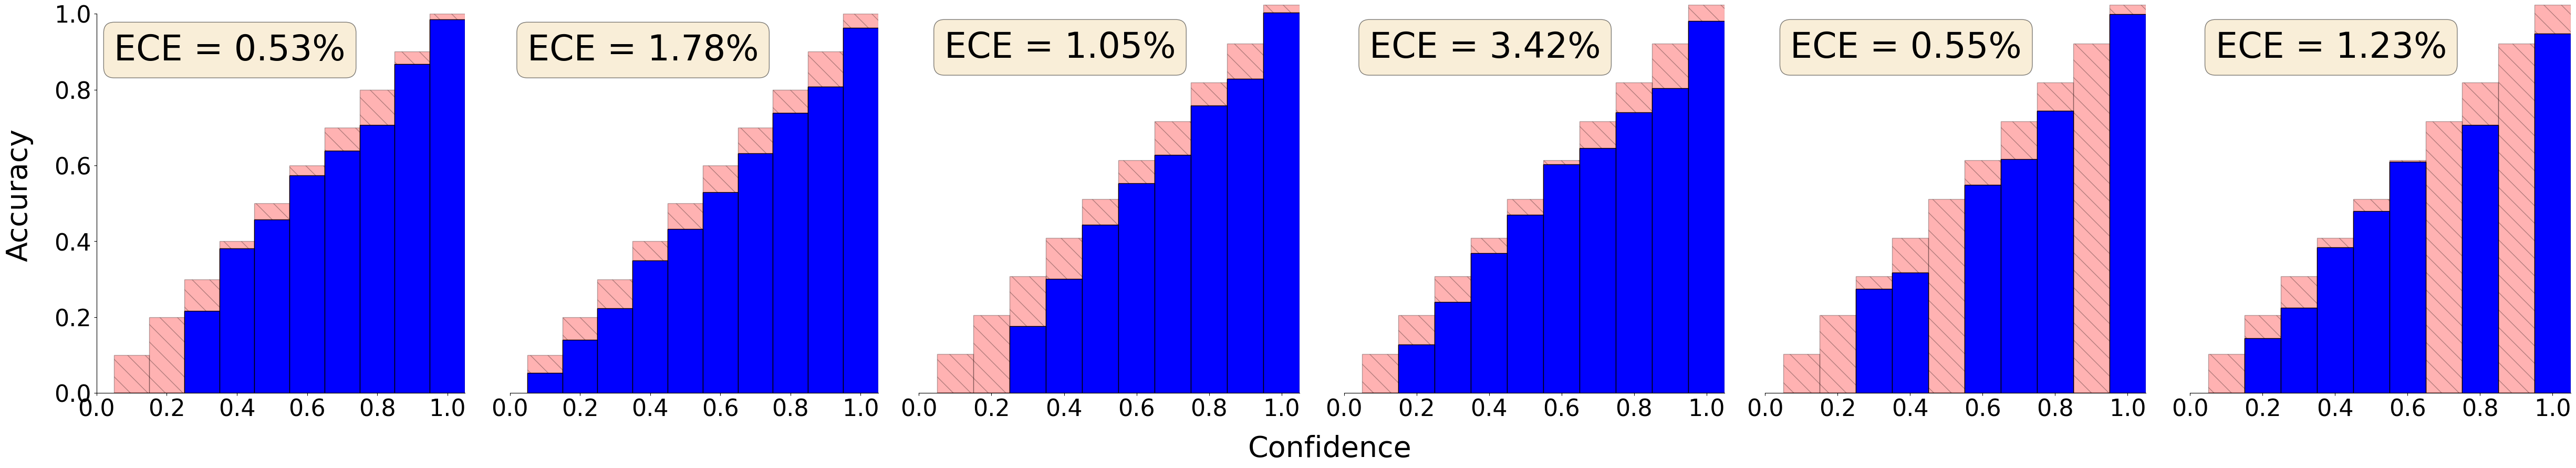

In [26]:
import matplotlib

matplotlib.rc('xtick', labelsize=32) 
matplotlib.rc('ytick', labelsize=32) 
fig = plt.figure( constrained_layout=True, figsize=(48,8))
#fig.suptitle('Reliability Diagram', fontsize=32)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=1, ncols=3)
names = {
    0 : 'Unsupervised Temperature Scaling',
    1 : 'Isotonic Regression',
    2 : 'Histogram Binning'
}

for row, subfig in enumerate(subfigs):
    #subfig.suptitle(names[row], fontsize=30, y=1.07)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        #if row == 0:
        #if col == 0:
        #        ax.set_title('CIFAR10', fontsize=28)
        #else:
        #        ax.set_title('CIFAR100', fontsize=28)
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1)
        ax.set_xticks(np.arange(0,1.01, 0.2))
        ax.bar(bins_utc_cifar10, bins_utc_cifar10,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

        #ax.plot([0,1],[0,1], '--', color='gray', linewidth=2)
        #ax.set_aspect('equal', adjustable='box')
        ax.spines[['right', 'top']].set_visible(False)
        if not (row ==0 and col == 0):
                ax.axes.get_yaxis().set_visible(False)
                ax.spines[['left']].set_visible(False)

ece_fontsize=48
# UTC
# CIFAR10
axarr = subfigs[0].get_axes()
axarr[0].bar(bins_utc_cifar10, bin_accs_utc_cifar10, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins_utc_cifar10, np.minimum(bins_utc_cifar10, bin_accs_utc_cifar10), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE_utc_cifar10*100),  fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# CIFAR100
axarr[1].bar(bins_utc_cifar100, bin_accs_utc_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_utc_cifar100, np.minimum(bins_utc_cifar10, bin_accs_utc_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')
axarr[1].text(0.05, 0.95, 'ECE = {:.2f}%'.format(ECE_utc_cifar100*100), fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        

# Isotonic CIFAR10
axarr = subfigs[1].get_axes()
axarr[0].bar(bins_iso_cifar10, bin_accs_iso_cifar10, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins_iso_cifar10, np.minimum(bins_iso_cifar10, bin_accs_iso_cifar10), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_iso_cifar10*100),  fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Isotonic CIFAR100
axarr[1].bar(bins_iso_cifar100, bin_accs_iso_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_iso_cifar100, np.minimum(bins_iso_cifar100,bin_accs_iso_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[1].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_iso_cifar100*100),  fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histobin CIFAR10
axarr = subfigs[2].get_axes()
axarr[0].bar(bins_histobin_cifar10, bin_accs_histobin_cifar10, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[0].bar(bins_histobin_cifar10, np.minimum(bins_histobin_cifar10, bin_accs_histobin_cifar10), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[0].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_histobin_cifar10*100), fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histobin CIFAR100
axarr[1].bar(bins_histobin_cifar100, bin_accs_histobin_cifar100, width=0.1, alpha=0.7, edgecolor='red', color='purple')
axarr[1].bar(bins_histobin_cifar100, np.minimum(bins_histobin_cifar100,bin_accs_histobin_cifar100), width=0.1, alpha=1, edgecolor='black', color='b')

axarr[1].text(0.07, 0.935, 'ECE = {:.2f}%'.format(ECE_histobin_cifar100*100), fontsize=ece_fontsize,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))





subfigs[-1].text(-0.5,-0.08, 'Confidence', ha='center', fontsize=40)
subfigs[-1].text(-2.08,0.4, 'Accuracy', ha='center', rotation=90, fontsize=40)

Text(-2.085, 0.04, 'Sample frac.')

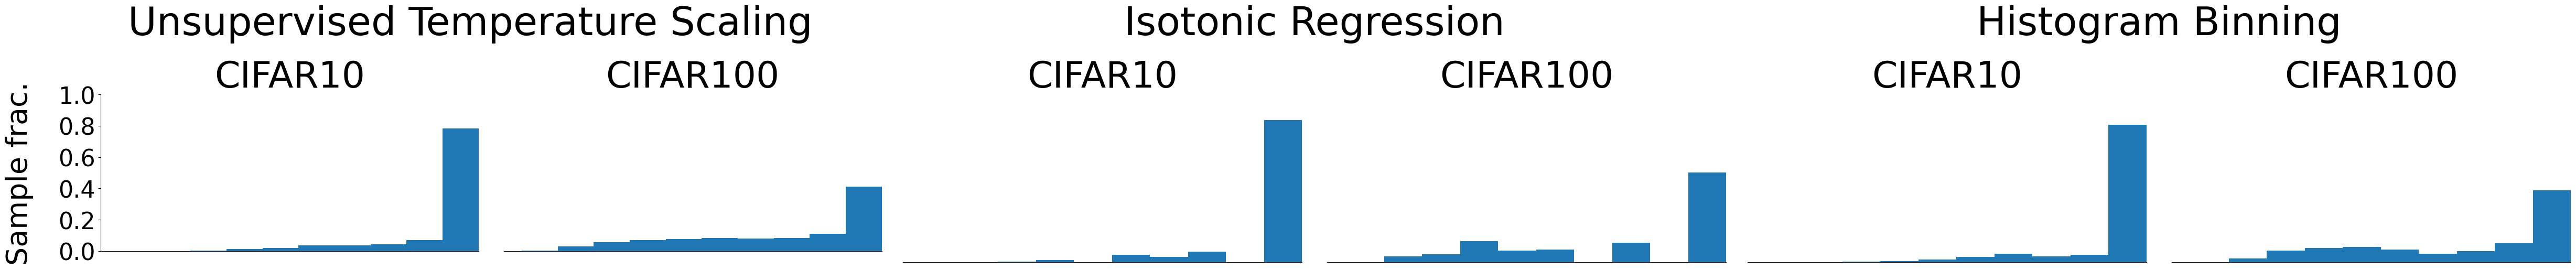

In [29]:
import matplotlib
# Plot histogram confidences
matplotlib.rc('xtick', labelsize=32) 
matplotlib.rc('ytick', labelsize=32) 
fig = plt.figure( constrained_layout=True, figsize=(48,4))
#fig.suptitle('Reliability Diagram', fontsize=32)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=1, ncols=3)
names = {
    0 : 'Unsupervised Temperature Scaling',
    1 : 'Isotonic Regression',
    2 : 'Histogram Binning'
}

for row, subfig in enumerate(subfigs):
    subfig.suptitle(names[row], fontsize=54, y=1.25)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        #if row == 0:
        if col == 0:
                ax.set_title('CIFAR10', fontsize=50)
        else:
                ax.set_title('CIFAR100', fontsize=50)
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        #ax.axes.get_xaxis().set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        if not (row ==0 and col == 0):
                ax.axes.get_yaxis().set_visible(False)
                ax.spines[['left']].set_visible(False)
        else:
            ax.set_yticks(np.arange(0, 1.01, 0.2), loc="top")
            

#x,_, p = plt.hist()
#for item in p:
#    item.set_height(item.get_height()/sum(x))
#plt.ylim([0,1.0])

xbins = np.insert(bins_iso_cifar100, 0, 0.0)


# Before Calibration
axarr = subfigs[0].get_axes()
for i, pr in enumerate([probs_uts, probs_uts_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  

# Scaled
axarr = subfigs[1].get_axes()
for i, pr in enumerate([p_calibrated_dt, p_calibrated_dt_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  

# Supervised
axarr = subfigs[2].get_axes()
for i, pr in enumerate([p_calibrated_iso, p_calibrated_iso_cifar100]):
    x,_, p =  axarr[i].hist(pr, xbins, density=True, align='right')     
    for item in p:
        item.set_height(item.get_height()/sum(x))  


#subfigs[-1].text(0,-0.08, 'Confidence', ha='center', fontsize=28)
subfigs[-1].text(-2.085,0.04, 'Sample frac.', ha='center', rotation=90, fontsize=40)